# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import pickle
import imageio
import math


%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


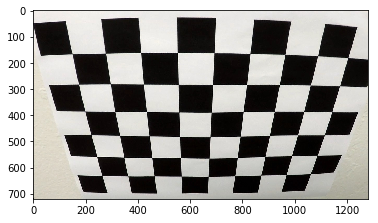

In [2]:
#reading in an image
image = mpimg.imread('./camera_cal/calibration2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
#plt.imshow(gray, cmap='gray')




## Finding Corners

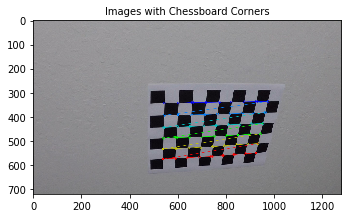

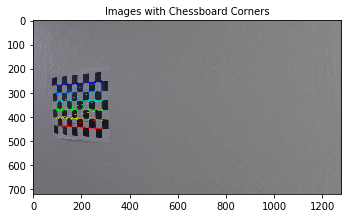

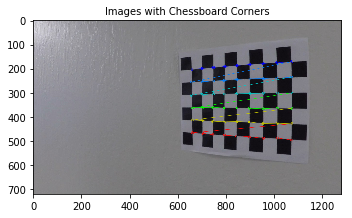

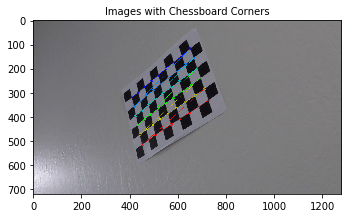

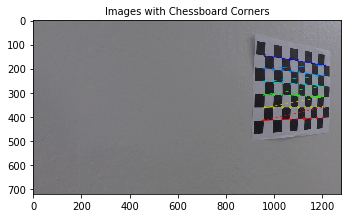

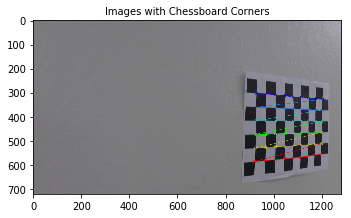

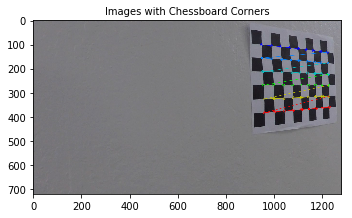

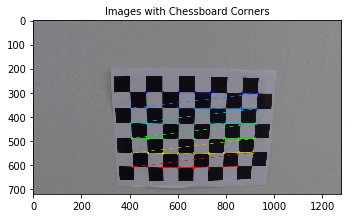

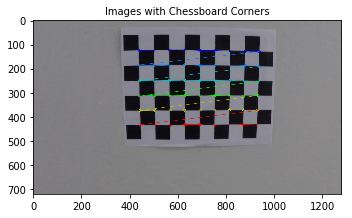

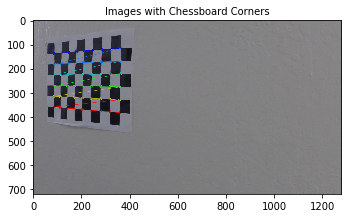

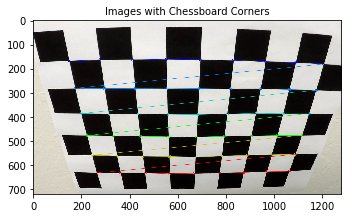

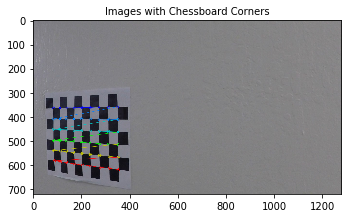

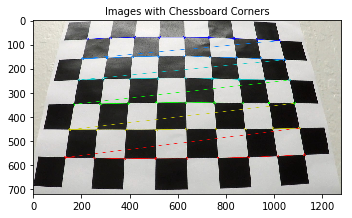

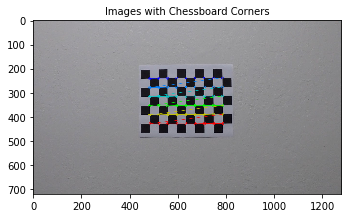

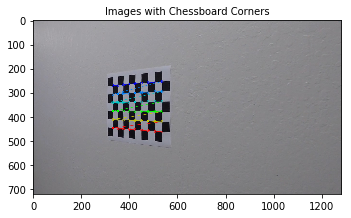

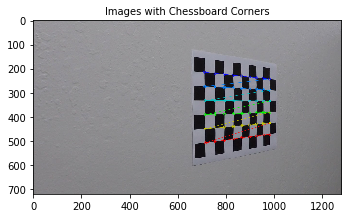

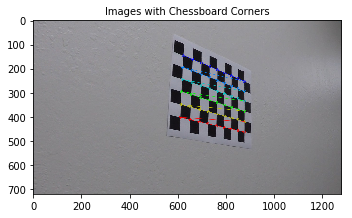

In [3]:
import glob
import os
#%matplotlib qt

images = glob.glob('./camera_cal/calibration*.jpg')
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image place

#Prepare object points like (0,0,0), (1,0,0), (2,0,0)......,(7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x,y coordinates

for fname in images:
    img = mpimg.imread(fname)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    #print("ret:",ret)
    #print("corners:",corners)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        imgDrawCorners = cv2.drawChessboardCorners(img,(9,6), corners, ret)
        #plt.imshow(imgDrawCorners)
        
        f, (ax1) = plt.subplots(1, figsize=(8, 3))
        f.tight_layout()
        ax1.imshow(imgDrawCorners)
        ax1.set_title('Images with Chessboard Corners', fontsize=10)
        
        

## Test - Calibration and Undistortion

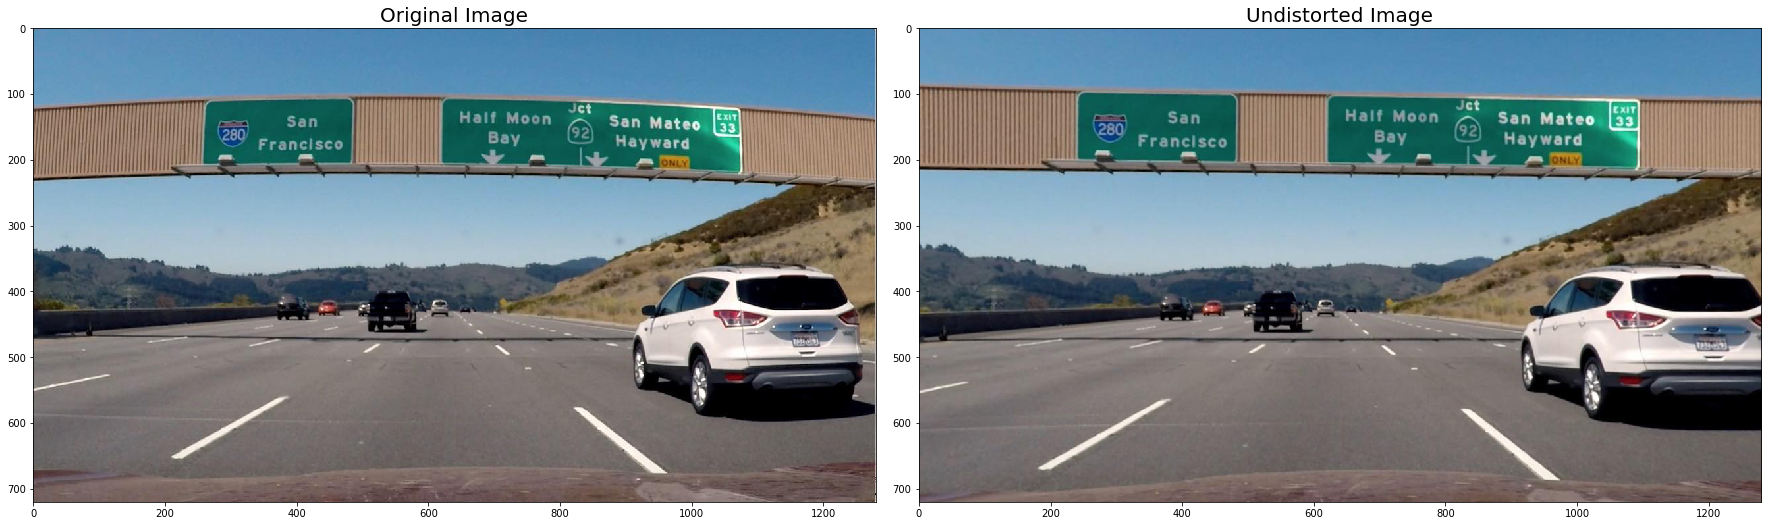

In [4]:
testImg = mpimg.imread('./test_images/z280.jpg')
#gray = cv2.cvtColor(testImg,cv2.COLOR_RGB2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dstTestImage = cv2.undistort(testImg, mtx, dist, None, mtx)
dstTestImageGray = cv2.cvtColor(dstTestImage,cv2.COLOR_RGB2GRAY)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImg)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dstTestImage)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


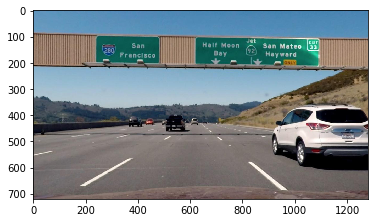

In [5]:
#%matplotlib qt
plt.imshow(dstTestImage)
plt.show()

In [6]:
#%matplotlib inline

src = np.float32(
    
        [[570, 460],
         [110, 720],
         [1010, 720],
         [680, 460]])
    
    
dst = np.float32(
        [[250, 0],
        [250, 720],
        [970, 720],
        [970, 0]])

img_size = (img.shape[1], img.shape[0])

    
M = cv2.getPerspectiveTransform(src, dst)
    
Minv = cv2.getPerspectiveTransform(dst, src)
    
def warp(img):
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image

    return warped

    

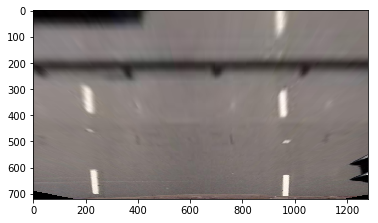

In [7]:
#%matplotlib qt
warpTest = warp(dstTestImage)
plt.imshow(warpTest)
plt.show()

In [17]:

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x',sobel_kernel=15, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    
    


### Pipeline and Related methods like histogram peaks/sliding windows/getRadius/getVehiclePosition

In [28]:
from collections import deque

historyLeft = deque(maxlen = 10)
historyRight = deque(maxlen = 10)


def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    #print("img.shape",img.shape)
    # Convert to HLS color space and separate the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    scaled_sobel = mag_thresh(img, 3, (30,100))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return color_binary


def pipeline2(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    #print("img.shape",img.shape)
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)#Originally 0,255
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)#Originally 0,255
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))#Originally 0,255
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))# Originally 0, np.pi/2
    
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

def undistortImage(inputImage):
    dstTestImage = cv2.undistort(inputImage, mtx, dist, None, mtx)
    return dstTestImage

def findHistogramPeaks(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #plt.plot(histogram)
    #plt.imshow(binary_warped)
    
    out_img = binary_warped.astype('uint8') 
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint], axis = 0).max()
    rightx_base = np.argmax(histogram[midpoint:],axis=0).max() + midpoint
    
    
    #plt.plot(histogram)
    
    return leftx_base, rightx_base
    

def slidingWindow(binary_warped,leftx_base,rightx_base):
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = binary_warped.astype('uint8')

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial 
    
    # If points found, also store it in a history queue datastructure, for future purposes, if no points found then.
    # If no points founds, then take the average of the points from last few frames. 
    if len(lefty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        historyLeft.append(left_fit)
        
    else:
        sumHistoryLeft = 0
        indexLeft = 0
        avgLeft = 0
        for itemLeft in historyLeft:
            sumHistoryLeft += itemLeft
            indexLeft += 1
        if indexLeft != 0:
            avgLeft = sumHistoryLeft/indexLeft
        else:
            avgLeft = 0
        left_fit = avgLeft
            
            
    
    if len(righty) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        historyRight.append(right_fit)
    else:
        sumHistoryRight = 0
        indexRight = 0
        avgRight = 0
        for itemRight in historyRight:
            sumHistoryRight += itemRight
            indexRight += 1
        if indexRight != 0:
            avgRight = sumHistoryRight/indexRight
        else:
            avgRight = 0
        right_fit = avgRight
        

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def getRadius(ploty, left_fit, right_fit, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad + right_curverad)/2.0


def getVehiclePosition(imageInput, left_fitx,right_fitx):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    cameraPosition = imageInput.shape[1]/2
    centerOfLane = (right_fitx[imageInput.shape[0]-1] + left_fitx[imageInput.shape[0]-1]) / 2
    offset = (cameraPosition - centerOfLane)*xm_per_pix
    return offset
    


### Method that calls the pipeline. Called by video frames

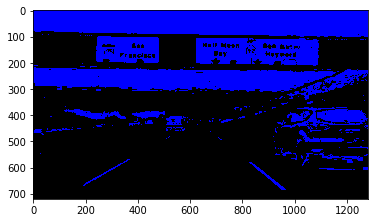

In [29]:
def plotLinesNew(imageInput):
    
    undistortedImage = undistortImage(imageInput)
    binary_image = pipeline(undistortedImage,(90,255))
    plt.imshow(binary_image)
    binary_warped = warp(binary_image)
    
    leftBase, rightBase = findHistogramPeaks(binary_warped)
    
    left_fitx, right_fitx, ploty, left_fit, right_fit = slidingWindow(binary_warped, leftBase, rightBase)
    
    color_warp = binary_warped.astype(np.uint8)


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imageInput.shape[1], imageInput.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undistortedImage , 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Radius of Curvature = {}(m)'.format(int(getRadius(ploty,left_fit,right_fit, left_fitx, right_fitx))),
                (50, 50), cv2.FONT_HERSHEY_PLAIN , 3.5, (255,255,255))

        
    cv2.putText(result, 'Vehicle is {0:.3f}m off center'.format(getVehiclePosition(imageInput, left_fitx, right_fitx)),
                (50, 100), cv2.FONT_HERSHEY_PLAIN , 3.5, (255,255,255))
    
    return result
    

image = cv2.imread("test_images/z280.jpg")
outputImage = plotLinesNew(image)
    
    



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [30]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg',
 'z280.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

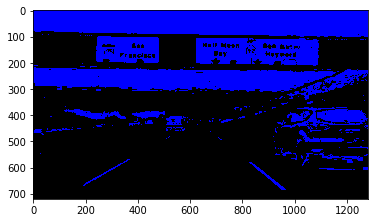

In [31]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#import imageio

def plotLinesAndSaveToDisk():
    testImageDir = "test_images/"
    outputImageDir = "output_images/"
    list = os.listdir("test_images/")
    #print ("countList:",list.count)
    for imgName in os.listdir("test_images/"):
        imagePath = testImageDir + imgName
        
         
        try:
            im = cv2.imread(imagePath)
            imageWithLine = plotLinesNew(im)
            outputPath = outputImageDir +"output"+ imgName 
            cv2.imwrite(outputPath, imageWithLine)
            
        except ValueError as e:
            print("Unable to open file")
            #print('errno:', e.errno)
        
            
plotLinesAndSaveToDisk()


### Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputVideo = 'project_video_out.mp4'
inputVideo  = VideoFileClip("project_video.mp4")

clip = inputVideo.fl_image(plotLinesNew)

%time clip.write_videofile(outputVideo, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputVideo))